Import Data

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlt

data = pd.read_stata("callreports_final.dta", chunksize=100000, preserve_dtypes=True)

df_raw = pd.DataFrame()

for chunk in data:
    df_raw=df_raw.append(chunk)

Additional Settings

In [168]:
%matplotlib inline
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib import ticker
import matplotlib.patches as mpatches
from scipy.stats import pearsonr

pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18

#setting matplotlib style
plt.style.use('default')

#setting params for matplolib plots
plt.rcParams['font.size']=BIGGER_SIZE          # controls default text sizes
plt.rcParams['axes.titlesize']=BIGGER_SIZE     # fontsize of the axes title
plt.rcParams['axes.labelsize']=BIGGER_SIZE    # fontsize of the x and y labels
plt.rcParams['xtick.labelsize']=BIGGER_SIZE    # fontsize of the tick labels
plt.rcParams['ytick.labelsize']=BIGGER_SIZE    # fontsize of the tick labels
plt.rcParams['legend.fontsize']=BIGGER_SIZE    # legend fontsize
plt.rcParams['figure.titlesize']=BIGGER_SIZE  # fontsize of the figure title
plt.rcParams['xtick.bottom']=True  # fontsize of the figure title
plt.rcParams['xtick.major.bottom']=True  # fontsize of the figure title
plt.rcParams['xtick.major.size']=3.5  # fontsize of the figure title
#plt.rcParams['xtick.major.width']=1  # fontsize of the figure title
plt.rcParams['xtick.major.top']=False  # fontsize of the figure title
plt.rcParams['xtick.minor.bottom']=True  # fontsize of the figure title
plt.rcParams['xtick.minor.size']=3  # fontsize of the figure title
#plt.rcParams['legend.fontsize'] = 22

#setting grid style
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5




Structural adjustments on dataset

In [169]:
#removing investment banks Goldman Sachs and Morgan Stanley
df_raw = df_raw[(df_raw.rssdid!=1456501) & (df_raw.bhcid!=2380443)]

Timeseries labels for xaxis 

In [170]:
years = [str(year) for year in range(1976, 2014)]

years16 = [str(year) for year in range(1976, 2014, 4)]

In [171]:
def plot_crisis(ax):
    #1980 crisis
    ax.axvspan(16, 19, alpha=0.5, color='red')


    #1981Q3-1982Q4 crisis
    ax.axvspan(22, 27, alpha=0.5, color='red')

    #1990Q3-1991Q2 crisis
    ax.axvspan(58, 61, alpha=0.5, color='red')

    #2001Q2-2001Q4 crisis
    ax.axvspan(101, 103, alpha=0.5, color='red')

    #2007Q4-2009Q3 crisis
    ax.axvspan(127, 134, alpha=0.5, color='red')


Analysing asset side & liability side

In [172]:
#getting relevant data
df_assets = df_raw[["rssdid","bhcid",  "name", 'year', "quarter","assets", "cash"
             ,"fedfundsrepoasset" ,"securities","loansnet", "tradingassets"]]

df_liab = df_raw[["rssdid", "name", 'year', "quarter","assets", "equity","fedfundsrepoliab" ,
             "deposits","foreigndep", "otherborrowedmoney", "tradingliabilities","subordinateddebt", "liabilities"]]

#aggregate data by year and quarter
df_agg = df_assets.groupby(["year", "quarter"]).sum()
df_agg_liab = df_liab.groupby(["year", "quarter"]).sum()

#reset index
df_agg =df_agg.reset_index()
df_agg_liab =df_agg_liab.reset_index()

#clean fedfundsrepoasset by putting average for null value
average = (df_agg.loc[103].fedfundsrepoasset + df_agg.loc[105].fedfundsrepoasset) / 2
df_agg.loc[104].fedfundsrepoasset = average

#fix foreign deposits missing values by filling with average of before and after
average = (df_agg_liab.loc[28].foreigndep + df_agg_liab.loc[32].foreigndep) / 2
df_agg_liab.loc[29].foreigndep = average
df_agg_liab.loc[30].foreigndep = average
df_agg_liab.loc[31].foreigndep = average

#computing other assets and other liabilities
df_agg["otherassets"] = df_agg["assets"] - (df_agg.iloc[:,5:10].sum(axis=1))
df_agg["otherliab"] = df_agg_liab["assets"] - (df_agg_liab.iloc[:,4:11].sum(axis=1))
df_agg_liab["otherliab"] = df_agg_liab["assets"] - (df_agg_liab.iloc[:,4:11].sum(axis=1))

#clean dataframe of nan, inf and zeros


#getting right yscale
df_agg_scaled = df_agg/1000000000

#remove liabilities, its unnessesary
df_agg_liab.drop(["liabilities"], axis=1 , inplace=True)

#log liabilities
df_agg_liab_log = np.log(df_agg_liab.iloc[:,3:])
df_agg_liab_log = pd.concat([df_agg_liab.iloc[:,:3],df_agg_liab_log], axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


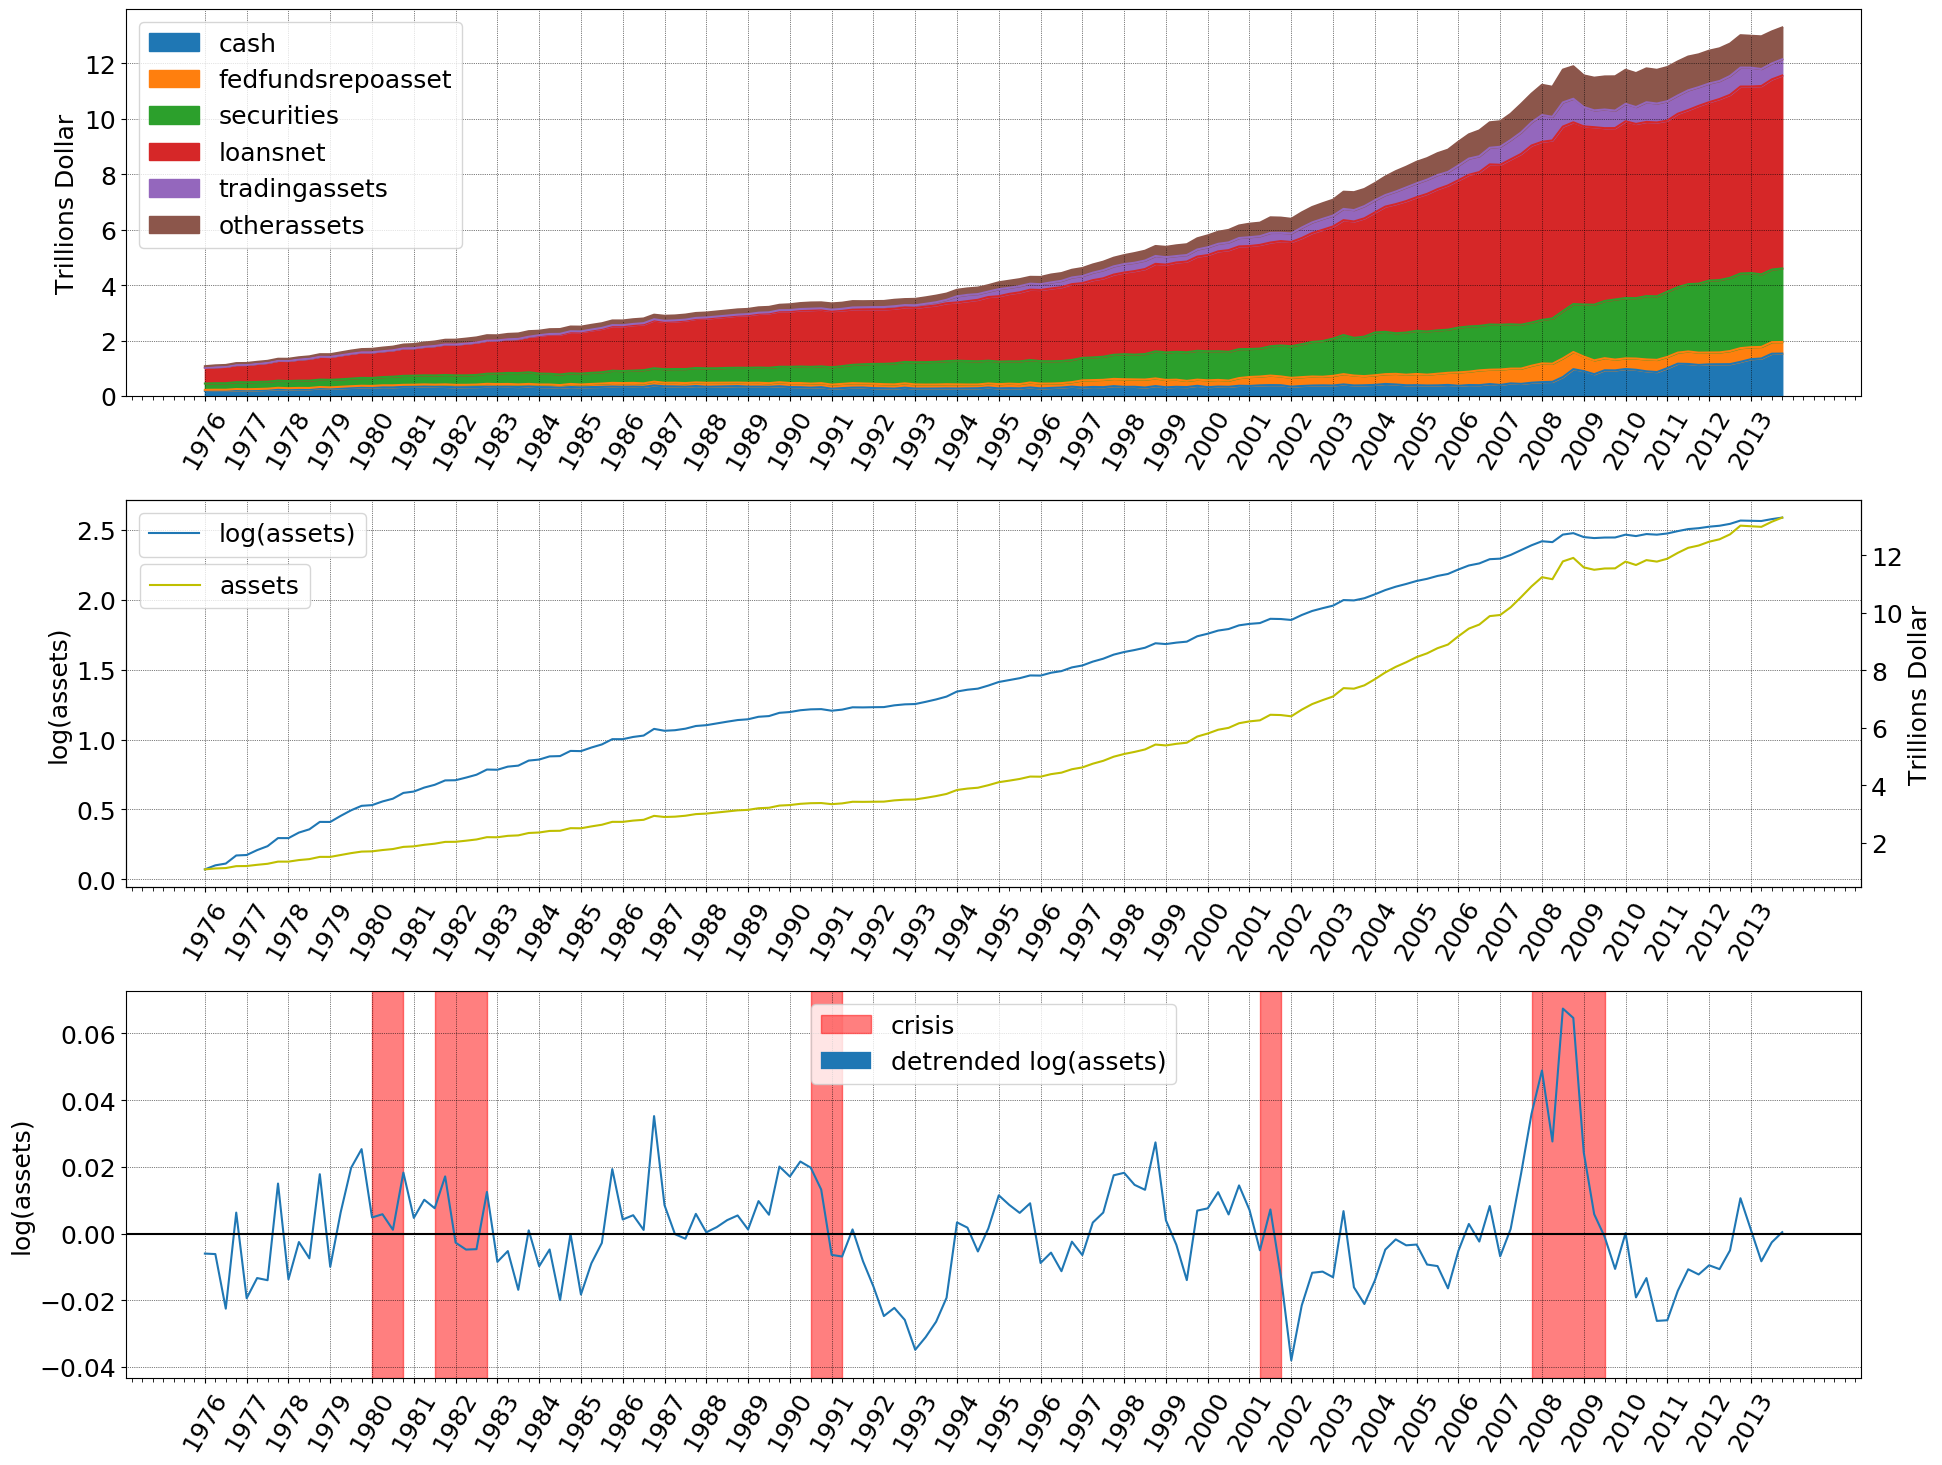

In [173]:
fig = plt.figure(figsize=(20,15))

#ax_twin = ax[1].twinx()

ax = fig.add_subplot(311)

#graph: absolute assets
ax.set_ylabel("Trillions Dollar")
df_agg_scaled.plot.area(ax=ax, y=["cash","fedfundsrepoasset" ,"securities",
                           "loansnet", "tradingassets", "otherassets"])
ax.set_xticks(range(0,151,4))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_xticklabels(years, rotation=60)
#ax.set_xlim(0, 151)
ax.legend()
ax.grid()

#ax.yaxis.set_major_formatter(mlt.ticker.StrMethodFormatter("{x:g}")) 

#graph: log(assets)
df_agg_log = np.log(df_agg_scaled)
ax1 = fig.add_subplot(312)
ax1.set_xticks(range(0,151,4))
ax1.xaxis.set_minor_locator(AutoMinorLocator(4))
df_agg_log.assets.plot(ax=ax1, color="C0")
ax1.set_xticklabels(years, rotation=60)
ax1.set_ylabel("log(assets)")
ax1.legend(["log(assets)"])
ax1.grid()
#ax1.set_xlim(0, 151)



#graph: cyclical of log(assets)
ax3 = fig.add_subplot(313)
cycle, trend = sm.tsa.filters.hpfilter(df_agg_log.assets, 1600)
df_agg_log["cycle"] = cycle
df_agg_log.cycle.plot(ax=ax3)

ax3.set_ylabel("log(assets)")
ax3.axhline(color="black")
ax3.set_xticks(range(0,151,4))
ax3.xaxis.set_minor_locator(AutoMinorLocator(4))
ax3.set_xticklabels(years, rotation=60)
red_patch = mpatches.Patch(color='red',alpha=0.5)
red_patch1 = mpatches.Patch(color='C0', lw=0.2)
ax3.legend(handles=[red_patch, red_patch1], labels=["crisis", "detrended log(assets)"])

ax3.grid()


plot_crisis(ax3)

#plot twin axis for second graph
ax_twin = ax1.twinx()
ax_twin.plot(df_agg_scaled.assets, "y")

ax_twin.legend(["assets"], loc=[0.008, 0.72])
ax_twin.set_ylabel("Trillions Dollar")


plt.tight_layout()

plt.savefig('LatexVorlage/graphs/DescriptiveStats/OtherAnalysis_clean_AssetDistribution_7613.png')

Cycle of both assets and liabilities positions

In [174]:

# choosing asset positions
df_agg_log_assets = df_agg_log.iloc[:, 5:11]

#choosing liabilities positions
df_agg_liab_log_positions =  df_agg_liab_log.iloc[:,4:13]

#concat
#df_agg_allpositions = pd.concat([df_agg_log_assets, df_agg_liab_log_positions], axis=1)
#index_year = df_agg_liab_log.iloc[:,:3] 
#df_agg_allpositions = pd.concat([index_year, df_agg_allpositions], axis=1)

#replace inf with nan
df_agg_liab_log_positions.replace([np.inf, -np.inf], np.nan, inplace=True)
df_agg_log_assets.replace([np.inf, -np.inf], np.nan, inplace=True)


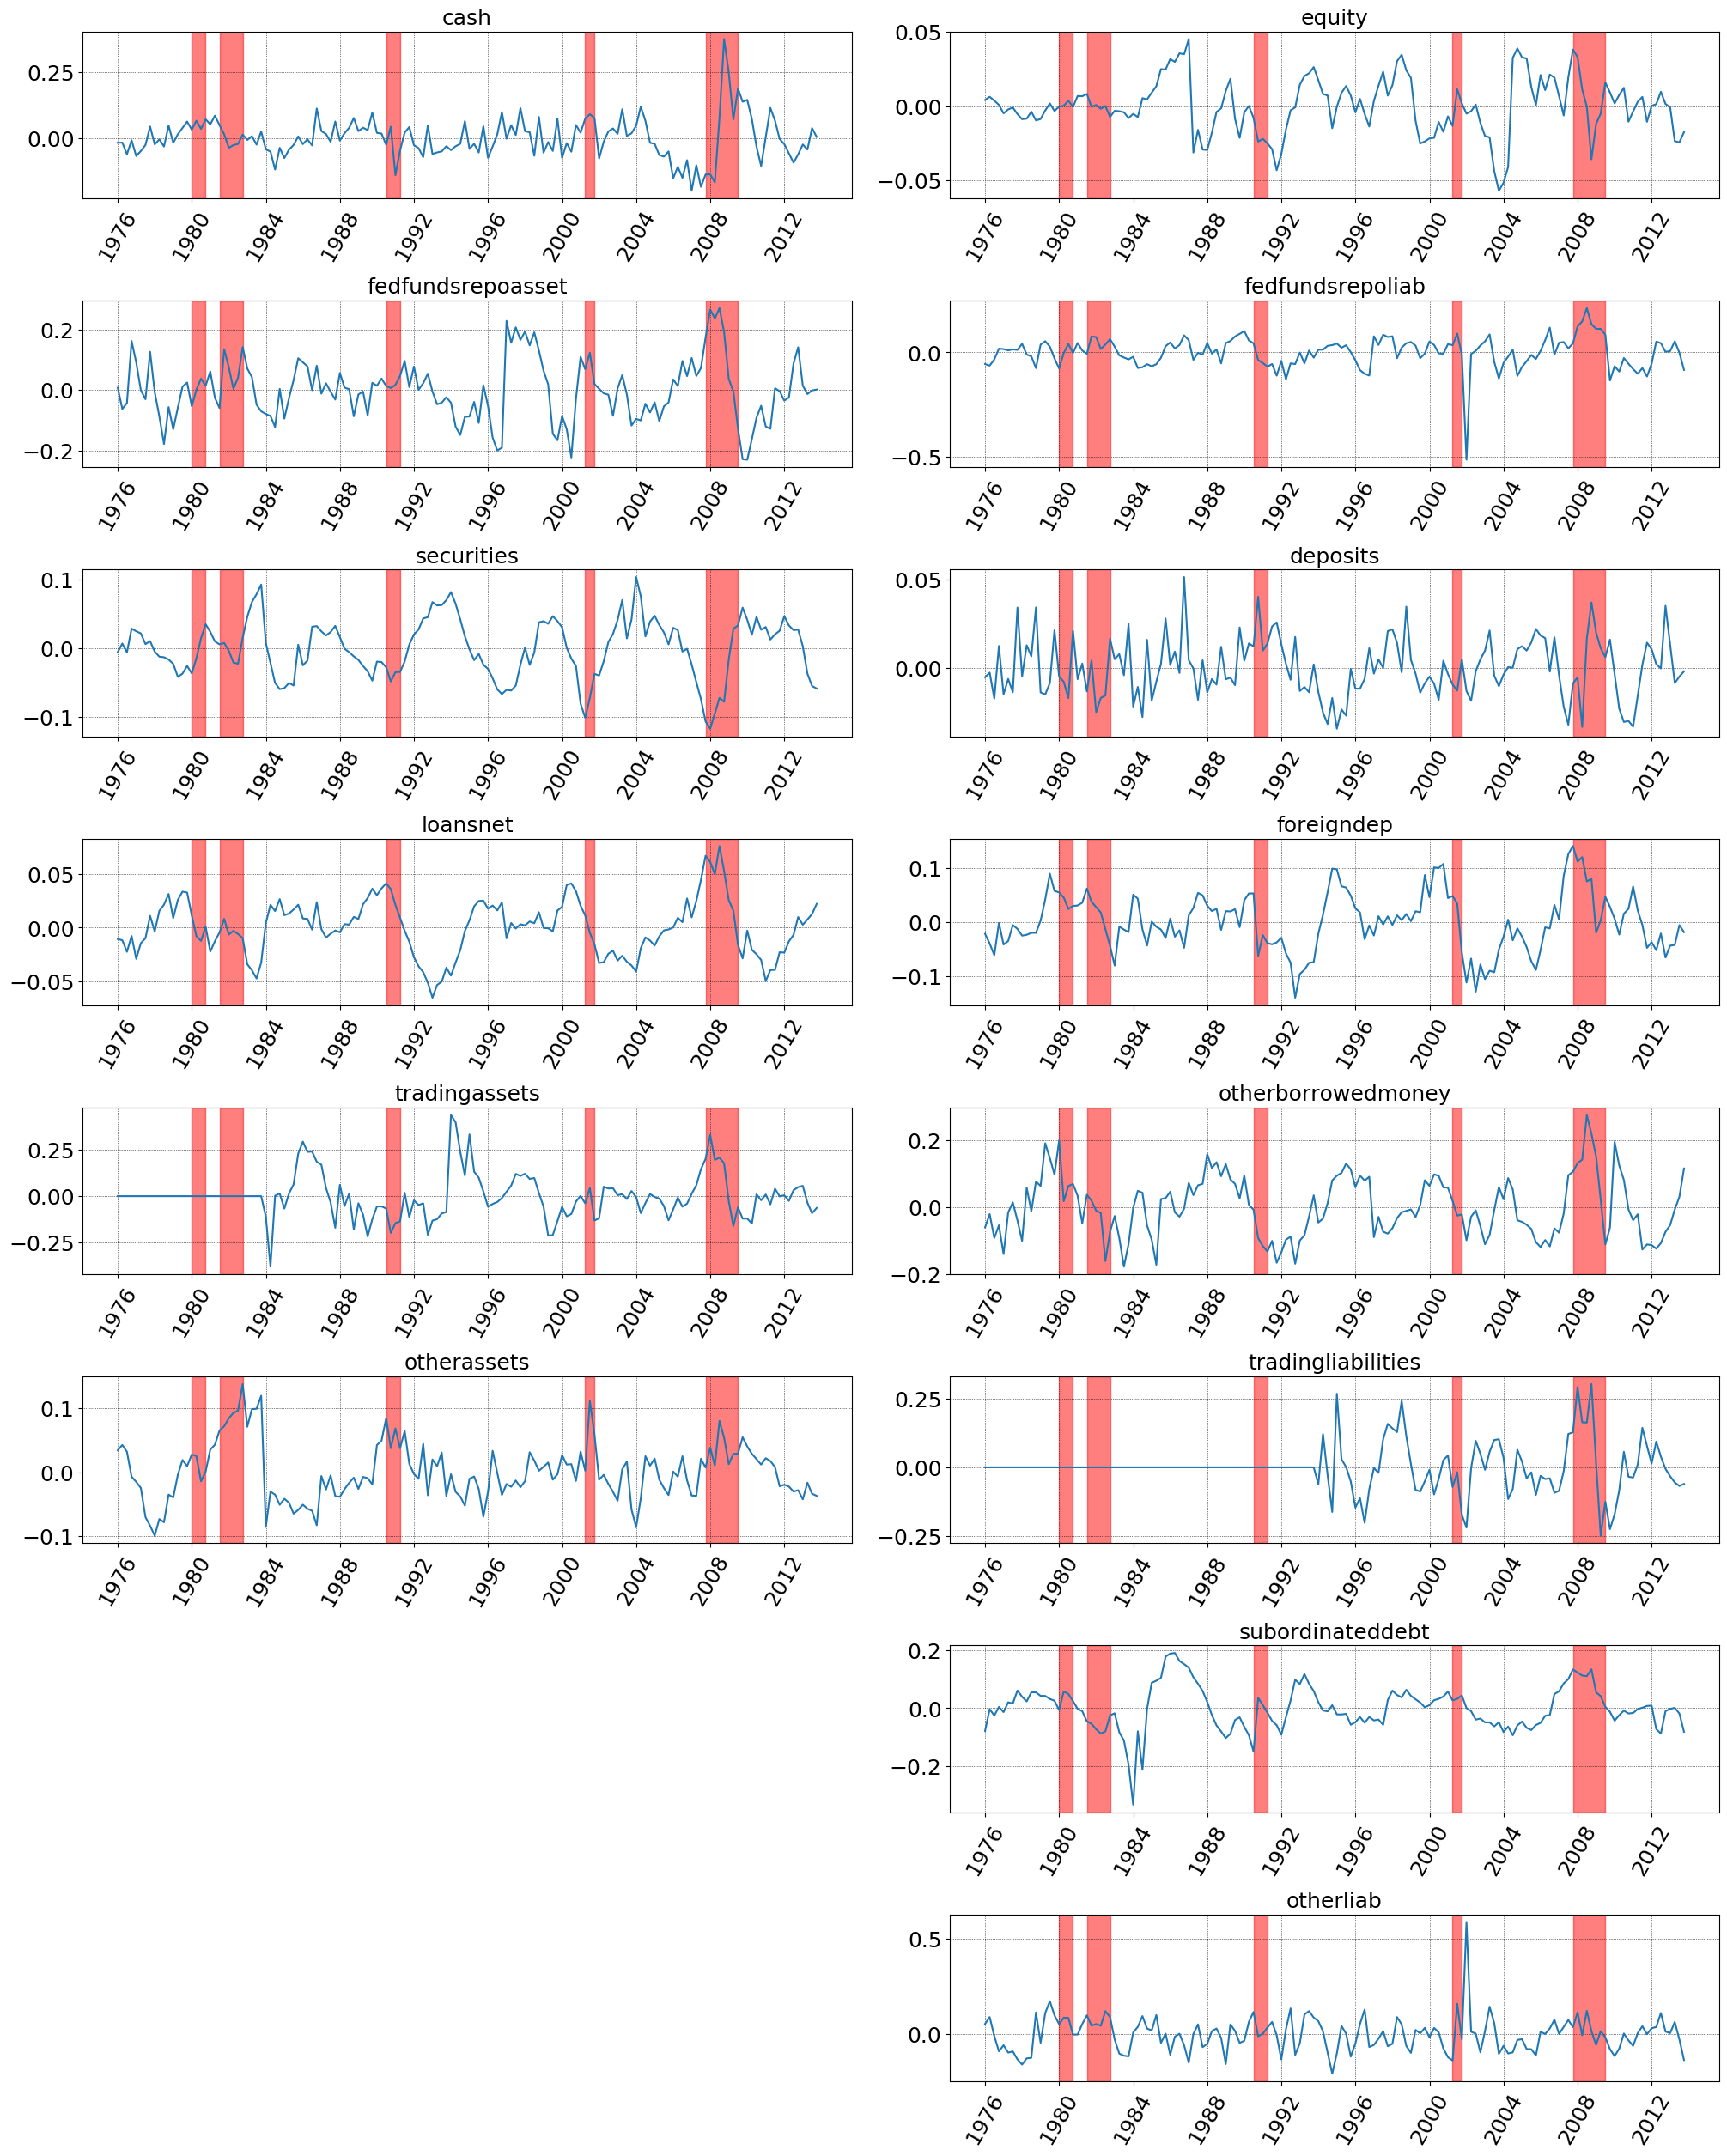

In [175]:
fig, ax = plt.subplots(8,2, figsize=(20,25), constrained_layout=True)
ax = ax.ravel()


#excluding other liabilities

#getting positon names
asset_positions_array = df_agg_log_assets.columns.values
liab_positions_array = df_agg_liab_log_positions.columns.values

#overall counter
i = 0

#asset positions counter
x = 0

#liabilities counter
y = 0

#dataframe to save all cycles
df_cycle_assets = pd.DataFrame()
df_cycle_liab = pd.DataFrame()

'''
This whole loop computes the the cycles for both asset and liabilities positions. It differentiates them,
so asset positions are plotted on the left column and liabilities positions on the right column.
Also, there are two cases, trading assets and trading liabilities which are treated special because of nan values
which mess up the cycle computation. 
'''

for i in range(16):
    #when we are in the left column and there is still an asset position
    if ((i % 2) == 0 and (x) < len(asset_positions_array)):
        #if position is tradingassets then fix wrong values
        if (asset_positions_array[x].startswith("trading")):
            #remove zeros for cycle estimation
            temp_series = df_agg_log_assets[asset_positions_array[x]]
            temp_series.dropna(inplace=True)
            #compute cycle
            cycle, trend = sm.tsa.filters.hpfilter(temp_series, 1600)
            #insert zeros back into cycle
            count_missing_values = 152 - cycle.size
            zeros = pd.Series(np.zeros(count_missing_values))
            cycle = pd.concat([zeros, cycle])
            ax[i].set_title(asset_positions_array[x])
            #save cycle
            df_cycle_assets[asset_positions_array[x]]=cycle
            #ax[i].set_ylabel("log(" + asset_positions_array[x] + ")")
        #not tradingassets then calculate cycle here
        else:
            #replace missing values with zero
            df_agg_log_assets[asset_positions_array[x]].fillna(0, inplace=True)
            #compute cycle
            cycle, trend = sm.tsa.filters.hpfilter(df_agg_log_assets[asset_positions_array[x]], 1600)
            ax[i].set_title(asset_positions_array[x])
            #save cycle
            df_cycle_assets[asset_positions_array[x]]=cycle
            #ax[i].set_ylabel("log(" + asset_positions_array[x] + ")")
        #plot cycle    
        ax[i].set_xticks(range(0,152,16))
        ax[i].set_xticklabels(years16, rotation=60)
        ax[i].plot(cycle)
        ax[i].grid()
        #plot crisis
        plot_crisis(ax[i])
        #increase asset counter by one
        x = x+1
    #when we are in the right column 
    elif ((i % 2) != 0):
        #if position is tradingliab then fix wrong values
        if (liab_positions_array[y].startswith("trading")):
            #remove zeros for cycle estimation
            temp_series = df_agg_liab_log_positions[liab_positions_array[y]]
            temp_series.dropna(inplace=True)
            #compute cycle
            cycle, trend = sm.tsa.filters.hpfilter(temp_series, 1600)
            #insert zeros back into cycle
            count_missing_values = 152 - cycle.size
            zeros = pd.Series(np.zeros(count_missing_values))
            cycle = pd.concat([zeros, cycle])
            ax[i].set_title(liab_positions_array[y])
            #save cycle
            df_cycle_liab[liab_positions_array[y]]=cycle
            #ax[i].set_ylabel("log(" + liab_positions_array[y] + ")")
        #not tradingassets then calculate cycle here
        else:
            #replace missing values with zero
            df_agg_liab_log_positions[liab_positions_array[y]].fillna(0, inplace=True)
            #compute cycle
            cycle, trend = sm.tsa.filters.hpfilter(df_agg_liab_log_positions[liab_positions_array[y]], 1600)
            ax[i].set_title(liab_positions_array[y])
            #save cycle
            df_cycle_liab[liab_positions_array[y]]=cycle
            #ax[i].set_ylabel("log(" + liab_positions_array[y] + ")")
        #plot cycle
        ax[i].set_xticks(range(0,152,16))
        ax[i].set_xticklabels(years16, rotation=60)
        ax[i].plot(cycle)
        y = y+1
        ax[i].grid()
        plot_crisis(ax[i])
    


fig.delaxes(ax[12])
fig.delaxes(ax[14])


plt.savefig('LatexVorlage/graphs/DescriptiveStats/OtherAnalysis_clean_PositionsCyclical_7613.png')

Compute correlation tables

In [223]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [224]:
corr_assets = df_cycle_assets.corr()

corr_liab = df_cycle_liab.corr()

corr_comb = df_cycle_liab.apply(lambda x: df_cycle_assets.corrwith(x))

In [225]:

cmap=sns.diverging_palette(220, 20, sep=20)

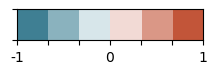

In [226]:
sns.palplot(cmap, size=0.4)

ax = plt.gca()

#ax.xaxis.set_major_locator(ticker.FixedLocator([-0.5,0.5,1.5,2.5,3.5,4.5,5.5]))
ax.xaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0))
ax.xaxis.set_major_formatter(ticker.FixedFormatter([-1,"","",0,"","",1 ]))
ax.tick_params(axis='both', which='major', labelsize=10)
#ax.set_xticks([-0.5,0.5,1.5,2.5,3.5,4.5,5.5])
#ax.set_xticklabels()

In [227]:
cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True)

pval = calculate_pvalues(corr_assets)

corr_assets.style.background_gradient(cmap, axis=None)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_precision(2)\

# create three masks
r1 = corr_assets.applymap(lambda x: '{}*'.format(x))
r2 = corr_assets.applymap(lambda x: '{}**'.format(x))
r3 = corr_assets.applymap(lambda x: '{}***'.format(x))
# apply them where appropriate
corr_assets = corr_assets.mask(pval<=0.1,r1)
corr_assets = corr_assets.mask(pval<=0.05,r2)
corr_assets = corr_assets.mask(pval<=0.01,r3)

corr_assets

,cash,fedfundsrepoasset,securities,loansnet,tradingassets,otherassets
cash,1.0***,-0.0744858,0.0588175,-0.00841654,-0.0805519,0.101566
fedfundsrepoasset,-0.0744858,1.0***,-0.342325,0.234596,0.342377,0.151737
securities,0.0588175,-0.342325,1.0***,-0.7257038602558901***,-0.116395,-0.00798202
loansnet,-0.00841654,0.234596,-0.7257038602558901***,1.0***,0.110938,-0.0616556
tradingassets,-0.0805519,0.342377,-0.116395,0.110938,1.0***,-0.117884
otherassets,0.101566,0.151737,-0.00798202,-0.0616556,-0.117884,1.0***


In [228]:
pval

,cash,fedfundsrepoasset,securities,loansnet,tradingassets,otherassets
cash,0,0.3996,0.7756,0.7634,0.3849,0.9577
fedfundsrepoasset,0.3996,0,0.1485,0.3169,0.3175,0.9828
securities,0.7756,0.1485,0,0.0028,0.5279,0.9746
loansnet,0.7634,0.3169,0.0028,0,0.6473,0.751
tradingassets,0.3849,0.3175,0.5279,0.6473,0,0.3792
otherassets,0.9577,0.9828,0.9746,0.751,0.3792,0


In [229]:
corr_liab.style.background_gradient(cmap, axis=None)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_precision(2)\

,equity,fedfundsrepoliab,deposits,foreigndep,otherborrowedmoney,tradingliabilities,subordinateddebt,otherliab
equity,1.00,0.17,-0.02,0.04,-0.06,0.12,0.27,0.07
fedfundsrepoliab,0.17,1.00,0.06,0.34,0.23,0.34,0.20,-0.25
deposits,-0.02,0.06,1.00,-0.34,-0.23,0.04,0.11,-0.12
foreigndep,0.04,0.34,-0.34,1.00,0.59,0.16,0.13,-0.03
otherborrowedmoney,-0.06,0.23,-0.23,0.59,1.00,0.08,0.15,-0.04
tradingliabilities,0.12,0.34,0.04,0.16,0.08,1.00,0.18,0.02
subordinateddebt,0.27,0.20,0.11,0.13,0.15,0.18,1.00,0.04
otherliab,0.07,-0.25,-0.12,-0.03,-0.04,0.02,0.04,1.00


In [231]:
corr_comb.style.background_gradient(cmap, axis=None)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_precision(2)\

,equity,fedfundsrepoliab,deposits,foreigndep,otherborrowedmoney,tradingliabilities,subordinateddebt,otherliab
cash,-0.25,0.10,0.38,0.04,0.28,-0.03,0.03,-0.18
fedfundsrepoasset,0.21,0.46,0.32,0.03,-0.12,0.48,0.30,0.13
securities,-0.06,-0.15,0.08,-0.38,-0.33,-0.16,-0.18,-0.20
loansnet,0.06,0.38,0.17,0.59,0.54,0.15,0.21,0.07
tradingassets,0.37,0.33,-0.09,0.23,0.14,0.49,0.35,-0.03
otherassets,0.02,0.10,-0.01,0.12,-0.07,0.04,-0.18,0.29


In [215]:
sns.palplot(cmap)

TypeError: object of type 'LinearSegmentedColormap' has no len()

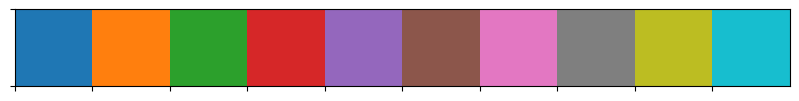

In [184]:
current_palette = sns.color_palette()
sns.palplot(current_palette)